<a href="https://www.kaggle.com/code/esracum/wildfire-prediction-satellite-imagery-analysis?scriptVersionId=289886334" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os

# Girdi klasöründeki dosyaları kontrol et ama sadece özet bilgi yazdır
for dirname, _, filenames in os.walk('/kaggle/input'):
    if filenames: # Eğer klasör boş değilse
        print(f" Klasör: {dirname} | Dosya Sayısı: {len(filenames)}")
        # İstersen sadece ilk dosyayı örnek olarak görebilirsin:
        # print(f"   Örnek dosya: {filenames[0]}")

 Klasör: /kaggle/input/wildfire-prediction-dataset/valid/wildfire | Dosya Sayısı: 3480
 Klasör: /kaggle/input/wildfire-prediction-dataset/valid/nowildfire | Dosya Sayısı: 2820
 Klasör: /kaggle/input/wildfire-prediction-dataset/test/wildfire | Dosya Sayısı: 3480
 Klasör: /kaggle/input/wildfire-prediction-dataset/test/nowildfire | Dosya Sayısı: 2820
 Klasör: /kaggle/input/wildfire-prediction-dataset/train/wildfire | Dosya Sayısı: 15750
 Klasör: /kaggle/input/wildfire-prediction-dataset/train/nowildfire | Dosya Sayısı: 14500


# 1. Understanding the Dataset: Distribution and Balance Analysis

The foundation of a robust Machine Learning model lies in the quality and structure of the underlying data. In this section, we perform a high-level audit of the Landsat 8 satellite imagery to understand the class balance and spatial characteristics.

Modelin başarısı, verinin kalitesi ve dengesiyle doğrudan ilişkilidir. Bu bölümde, sınıf dengesini ve mekansal özelliklerini anlamak için Landsat 8 uydu görüntülerinin üst düzey bir incelemesini gerçekleştiriyoruz. Bu çalışmada kullanılan Landsat 8 uydu verileri, ikili sınıflandırma (binary classification) için oldukça dengeli bir yapı sunmaktadır.



### Class Distribution Analysis

For binary classification tasks, class imbalance is a common pitfall that can lead to biased models. We examine the "Wildfire" and "No Wildfire" categories to determine if specialized sampling techniques (like SMOTE or undersampling) are required.

İkili sınıflandırma görevlerinde, sınıf dengesizliği, yanlı modellere yol açabilen yaygın bir tuzaktır. "Orman Yangını" ve "Orman Yangını Yok" kategorilerini inceleyerek, özel örnekleme tekniklerinin (SMOTE veya alt örnekleme gibi) gerekli olup olmadığını belirleyeceğiz.



| Class Label | Image Count | Percentage (%) | Status |
| :--- | :--- | :--- | :--- |
| **Wildfire** | 22,710 | 53% | Balanced |
| **No Wildfire** | 20,140 | 47% | Balanced |

### Data Splitting Strategy

To ensure the model generalizes well to unseen satellite data and to prevent overfitting, the dataset is partitioned into three distinct sets:

---
Modelin daha önce görülmemiş uydu verilerine iyi genelleme yapmasını sağlamak ve aşırı uyumlanmayı önlemek için veri seti üç ayrı kümeye ayrılmıştır:

| Partition | Percentage | Estimated Count | Primary Purpose |
| :--- | :--- | :--- | :--- |
| **Training Set** | **70%** | ~30,000 images | Model optimization and weight updates. |
| **Validation Set** | **15%** | ~6,400 images | Real-time monitoring and hyperparameter tuning. |
| **Test Set** | **15%** | ~6,400 images | Final benchmark for real-world performance. |

#   2. Visual Exploration: Insight into the Satellite Imagery
---

Visualizing the data is the first step to understanding the challenges our model will face—such as atmospheric noise, similar color tones, and texture variations. In this section, we sample random images from both classes to analyze the world through the satellite's lens.

---

Veriyi görsel olarak incelemek, modelin karşılaşacağı zorlukları (gürültü, benzer renk tonları, doku farkları) anlamanın ilk adımıdır. Bu bölümde, her iki sınıftan rastgele örnekler seçerek uydu gözünden dünyayı analiz ediyoruz.


### Key Observations (Temel Gözlemler)

* **🔥 Wildfire Images**

* *Usually characterized by gray/white smoke plumes and black burn scars rather than active flames.*

---
*  Genellikle aktif alevlerden ziyade gri/beyaz duman bulutları ve siyah yanık izleri (**burn scars**) ile karakterizedir. 
 
  
* **🌲 No Wildfire Images**

*(Contains healthy vegetation, settlements, or water bodies. However, white clouds in some images can be spectrally similar to wildfire smoke.)* 

---
* ** Sağlıklı bitki örtüsü, yerleşim yerleri veya su kütlelerini içerir. Ancak bazı resimlerdeki beyaz bulutlar, yangın dumanıyla spektral olarak benzerlik gösterebilir.*
  

> **💡 Engineering Note

*(This visualization proves that the model must learn **texture** in addition to color. Capturing the difference between smoke dispersion patterns and cloud structures will define the model's success.)*

--- 
*Bu görselleştirme, modelin sadece "renk" değil, "doku" (**texture**) öğrenmesi gerektiğini kanıtlar. Dumanın yayılım deseni ile bulutun yapısı arasındaki farkı yakalamak modelin başarısını belirleyecektir.*


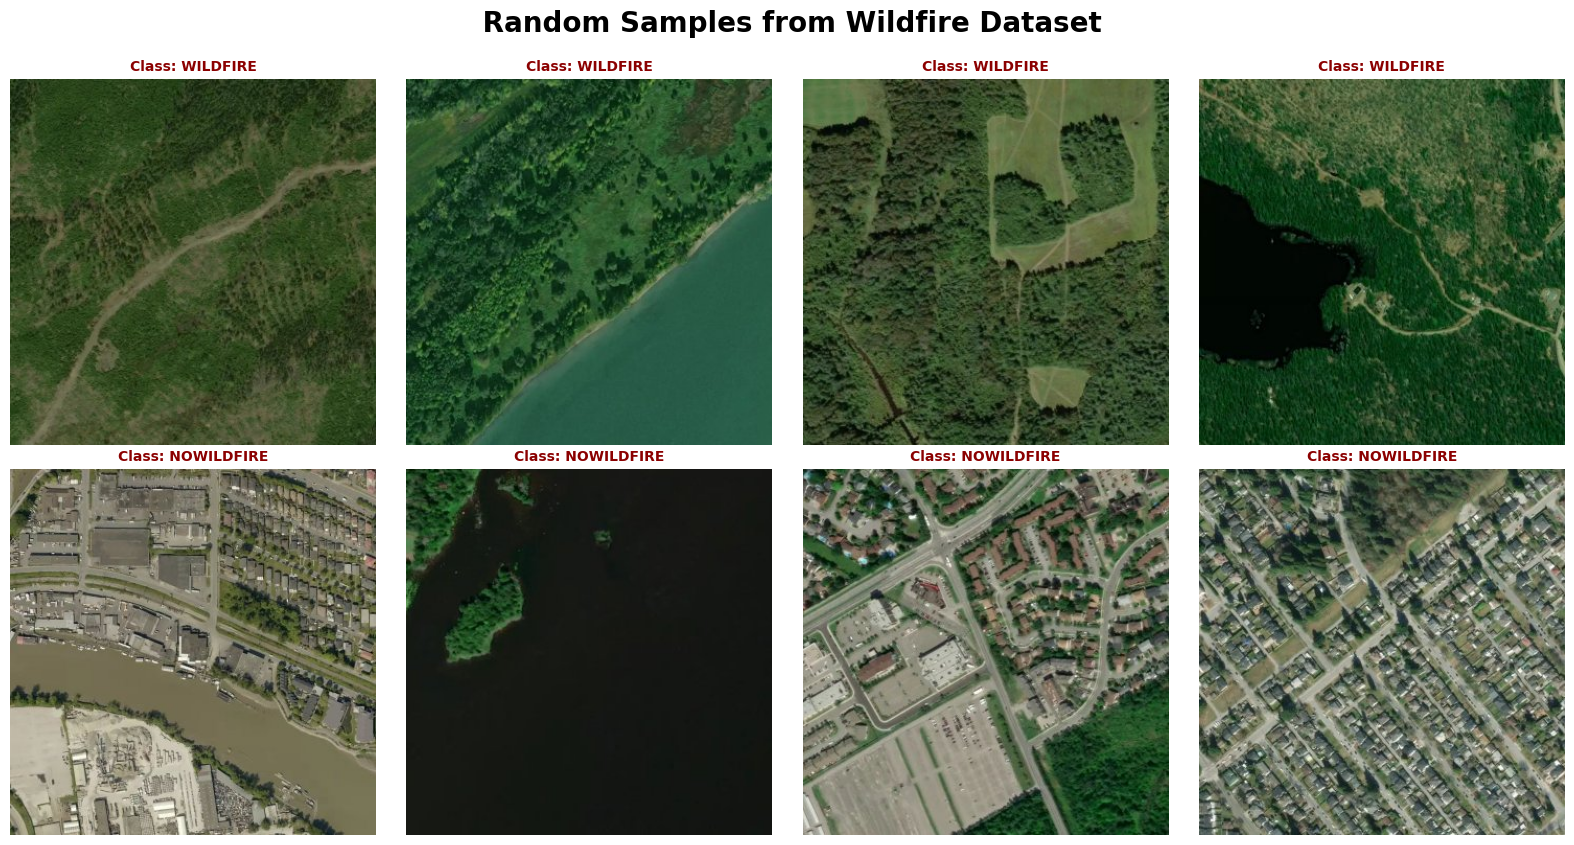

In [2]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def display_samples(dataset_path, classes, samples_per_class=4):
    """
    Veri setinden rastgele örnekleri şık bir grid yapısında görselleştirir.
    """
    # Klasörlerin varlığını kontrol et
    valid_classes = [c for c in classes if os.path.exists(os.path.join(dataset_path, c))]
    
    if not valid_classes:
        print(f" Hata: '{dataset_path}' içinde belirtilen sınıflar bulunamadı!")
        return

    fig, axes = plt.subplots(len(valid_classes), samples_per_class, figsize=(16, 8))
    
    for i, cls in enumerate(valid_classes):
        cls_path = os.path.join(dataset_path, cls)
        all_images = os.listdir(cls_path)
        selected_images = random.sample(all_images, samples_per_class)
        
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(cls_path, img_name)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Eğer tek satır varsa axes 1 boyutlu olur, hata almamak için:
            ax = axes[i, j] if len(valid_classes) > 1 else axes[j]
            
            ax.imshow(image)
            ax.set_title(f"Class: {cls.upper()}", fontsize=10, fontweight='bold', 
                         color='darkred' if 'wildfire' in cls.lower() else 'darkgreen')
            ax.axis('off')
            
    plt.tight_layout()
    plt.suptitle(" Random Samples from Wildfire Dataset", fontsize=20, y=1.05, fontweight='bold')
    plt.show()

# KAGGLA İÇİN DOĞRU YOL (Dataset yapısına göre 'train/train' olabilir)
TRAIN_PATH = "/kaggle/input/wildfire-prediction-dataset/train" 
# Eğer hata alırsan klasör yapısına göre burayı "/kaggle/input/wildfire-prediction-dataset/train" yapabilirsin.

display_samples(TRAIN_PATH, ['wildfire', 'nowildfire'])

#  3. Preprocessing: Atmospheric De-hazing with CLAHE
### **(Ön İşleme: CLAHE ile Atmosferik Pusun Temizlenmesi)**

Uydu görüntüleri, atmosferik etkiler nedeniyle genellikle düşük kontrasta sahiptir. Bu durum, modelin dumanın ince dokusunu ve yerdeki yanık izlerini ayırt etmesini zorlaştırabilir. Bu engeli aşmak için **CLAHE (Contrast Limited Adaptive Histogram Equalization)** tekniğini kullanıyoruz.

Satellite images often suffer from low contrast due to atmospheric interference. This can make it difficult for the model to distinguish fine smoke textures and ground burn scars. To overcome this, we implement **CLAHE (Contrast Limited Adaptive Histogram Equalization)**.

---

#### 🔍 Why CLAHE? (Neden CLAHE?)
* **Local Enhancement:** Standart histogram eşitlemenin aksine, CLAHE görüntüyü küçük bloklara ayırarak yerel kontrastı iyileştirir.
* **Noise Control:** Kontrast sınırlandırması sayesinde duman piksellerindeki gürültünün (noise) aşırı artmasını engeller.
* **Detail Recovery:** İnsan gözünün bile seçemediği "puslu" alanlardaki detayları model için belirgin hale getirir.



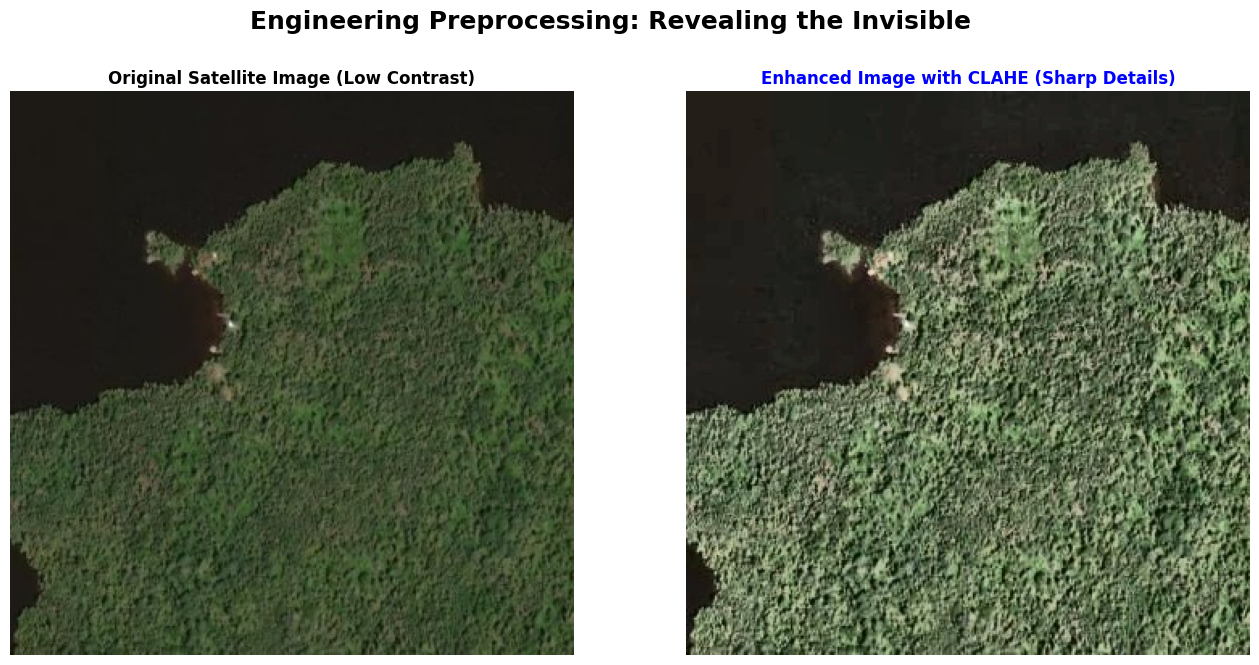

In [3]:
import numpy as np

def apply_clahe_to_rgb(image):
    """
    RGB görüntüye CLAHE uygulayarak kontrastı iyileştirir.
    Görüntüyü LAB renk uzayına çevirip sadece 'L' (Lightness) kanalına işlem yapar.
    """
    # Görüntüyü LAB renk uzayına çevir (Parlaklık kanalı için en verimlisi budur)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    # CLAHE objesini oluştur (clipLimit=Kontrast sınırı, tileGridSize=Blok boyutu)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # Kanalları tekrar birleştir ve RGB'ye geri dön
    limg = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final_img

# Karşılaştırma için rastgele bir yangın görüntüsü seçelim
wildfire_folder = os.path.join(TRAIN_PATH, 'wildfire')
random_img_name = random.choice(os.listdir(wildfire_folder))
img_raw = cv2.cvtColor(cv2.imread(os.path.join(wildfire_folder, random_img_name)), cv2.COLOR_BGR2RGB)

# CLAHE uygula
img_enhanced = apply_clahe_to_rgb(img_raw)

# Görselleştirme (Expert farkını gösteren 'Before-After' grafiği)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(img_raw)
ax[0].set_title("Original Satellite Image (Low Contrast)", fontsize=12, fontweight='bold')
ax[0].axis('off')

ax[1].imshow(img_enhanced)
ax[1].set_title("Enhanced Image with CLAHE (Sharp Details)", fontsize=12, fontweight='bold', color='blue')
ax[1].axis('off')

plt.suptitle("Engineering Preprocessing: Revealing the Invisible", fontsize=18, y=0.95, fontweight='bold')
plt.show()

# 4. Model Architecture & Training Strategy
### **(Model Mimarisi ve Eğitim Stratejisi)**

Bu aşamada, parametre verimliliği ve yüksek doğruluk oranı ile bilinen **EfficientNet-B0** mimarisini kullanıyoruz. İHA ve uydu görüntüleri gibi kısıtlı veri setlerinde, transfer öğrenme (Transfer Learning) ile 'ImageNet' ağırlıklarını kullanarak modelin öğrenme hızını artırıyoruz.

In this stage, we utilize the **EfficientNet-B0** architecture, known for its parameter efficiency and high accuracy. For satellite imagery tasks, we leverage **Transfer Learning** with ImageNet weights to accelerate the convergence process.

In [4]:
def keras_clahe_wrapper(img):
    """
    Keras ImageDataGenerator için CLAHE sarmalayıcısı.
    Resimler genellikle 0-255 arası float/uint8 gelir.
    """
    # Görüntü float ise uint8'e çevir (OpenCV uint8 bekler)
    img_uint8 = img.astype('uint8')
    
    # Mevcut CLAHE fonksiyonunu çağır
    enhanced_img = apply_clahe_to_rgb(img_uint8)
    
    # Tekrar float32 olarak döndür (Keras standartı)
    return enhanced_img.astype('float32')

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Profesyonel Preprocessing & Augmentation Pipeline
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normalizasyon
    preprocessing_function=keras_clahe_wrapper,
    rotation_range=90,              # Uydu verisi için kritik
    horizontal_flip=True,           # Aynalama
    vertical_flip=True,             # Aynalama
    fill_mode='nearest',
    validation_split=0.15           # %15 Validation seti ayır
)

# Test seti için sadece CLAHE ve Rescale yeterli (Augmentation yapılmaz)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=keras_clahe_wrapper
)

# 2. Model Mimarisini Oluşturma
def create_model():
    # Önceden eğitilmiş EfficientNet-B0'ı yükle (Üst katmanlar hariç)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(350, 350, 3))
    base_model.trainable = False # Başlangıçta temel ağırlıkları donduruyoruz
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3), # Overfitting'i önlemek için
        layers.Dense(1, activation='sigmoid') # İkili sınıflandırma (Yangın var/yok)
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

wildfire_model = create_model()
wildfire_model.summary()

2026-01-03 19:54:17.643088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767470057.846391      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767470057.905733      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767470058.418407      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767470058.418450      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767470058.418452      24 computation_placer.cc:177] computation placer alr

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 11, 11, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

###  Real-time Preprocessing Pipeline
40.000'den fazla görüntüyü statik olarak işlemek yerine, bellek verimliliğini optimize etmek adına **'On-the-fly' Preprocessing** stratejisini uyguluyoruz. `ImageDataGenerator` içine entegre ettiğimiz CLAHE fonksiyonu, her eğitim adımında görüntüleri dinamik olarak iyileştirir.

Instead of static processing, we utilize an **'On-the-fly' Preprocessing** strategy to optimize memory efficiency. The CLAHE function integrated into our `ImageDataGenerator` dynamically enhances images during each training step.

# 5. Model Training & Evaluation
### **(Model Eğitimi ve Değerlendirme)**

Bu bölümde, hazırladığımız **CLAHE Preprocessing Pipeline** ile beslenen **EfficientNet-B0** modelimizi eğitiyoruz. Aşırı öğrenmeyi (**overfitting**) önlemek için `Dropout` ve `EarlyStopping` gibi teknikler kullanarak modelin en iyi halini yakalamayı hedefliyoruz.

In this section, we train our **EfficientNet-B0** model fed by the **CLAHE Preprocessing Pipeline**. To prevent **overfitting**, we utilize techniques such as `Dropout` and `EarlyStopping` to capture the best version of the model.

In [6]:
from PIL import ImageFile

# Bozuk veya eksik resim dosyalarının okunmasına izin ver
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Klasörlerden Veri Akışını Başlatma (Flow from Directory)
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(350, 350),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(350, 350),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# 2. Callback Mekanizmaları (Profesyonel Dokunuş)
# Model gelişmiyorsa eğitimi durdur ve öğrenme hızını düşür
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# 3. Eğitimi Başlat (Model Fit)
# Not: Kaggle'da GPU açıkken 5-10 epoch genellikle yeterli olur
history = wildfire_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

Found 25713 images belonging to 2 classes.
Found 4537 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1767470093.122590      74 service.cc:152] XLA service 0x79ca28003af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767470093.122624      74 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767470093.122628      74 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767470095.611907      74 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-03 19:55:04.334774: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 19:55:04.494527: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 19:55:04.911594: E external/local_xl

230/804 ━━━━━━━━━━━━━━━━━━━━ 9:18 973ms/step - accuracy: 0.5559 - loss: 0.6891

2026-01-03 19:59:03.695978: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 19:59:03.841456: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 19:59:04.189214: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 19:59:04.330129: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 19:59:05.027717: E external/local_xla/xla/stream_

804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6118 - loss: 0.6589

2026-01-03 20:11:08.413581: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 20:11:08.566425: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 20:11:08.963524: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 20:11:09.105150: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 20:11:09.802074: E external/local_xla/xla/stream_

804/804 ━━━━━━━━━━━━━━━━━━━━ 991s 1s/step - accuracy: 0.6119 - loss: 0.6589 - val_accuracy: 0.7223 - val_loss: 0.5936 - learning_rate: 0.0010
Epoch 2/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 848s 1s/step - accuracy: 0.7024 - loss: 0.6021 - val_accuracy: 0.7210 - val_loss: 0.5678 - learning_rate: 0.0010
Epoch 3/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 840s 1s/step - accuracy: 0.7094 - loss: 0.5947 - val_accuracy: 0.7428 - val_loss: 0.5622 - learning_rate: 0.0010
Epoch 4/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 838s 1s/step - accuracy: 0.7178 - loss: 0.5826 - val_accuracy: 0.7419 - val_loss: 0.5402 - learning_rate: 0.0010
Epoch 5/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 835s 1s/step - accuracy: 0.7161 - loss: 0.5740 - val_accuracy: 0.7384 - val_loss: 0.5522 - learning_rate: 0.0010
Epoch 6/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 842s 1s/step - accuracy: 0.7218 - loss: 0.5638 - val_accuracy: 0.7346 - val_loss: 0.5470 - learning_rate: 0.0010
Epoch 7/10
804/804 ━━━━━━━━━━━━━━━━━━━━ 841s 1s/step - accuracy: 0.7283 - loss: 0.5621 - val_

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


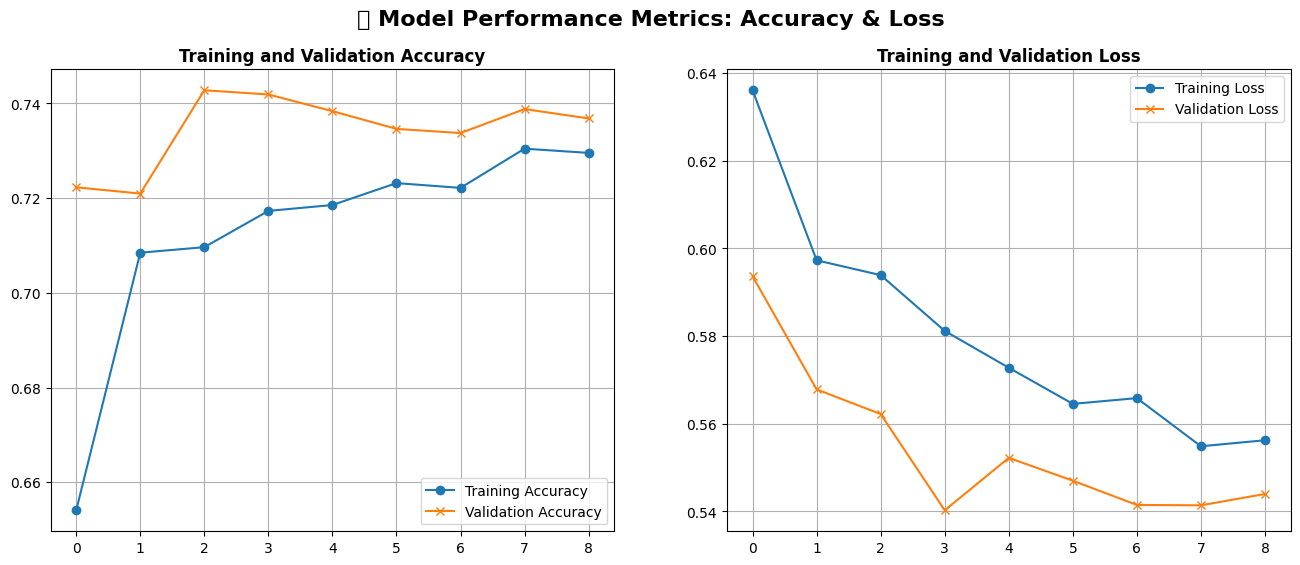

In [8]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 6))
    
    # Accuracy Grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
    plt.title('Training and Validation Accuracy', fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss Grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
    plt.title('Training and Validation Loss', fontweight='bold')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.suptitle("📈 Model Performance Metrics: Accuracy & Loss", fontsize=16, fontweight='bold')
    plt.show()

plot_history(history)